In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn
import pandas
import numpy


In [3]:

def farenheight_to_celcius(values):
    return (values - 32) * 5/9.0 
    
def load_data(path, resample=None):

    df = pandas.read_csv(path)

    df.columns = [c.strip().removeprefix('AHU: ').removesuffix('Signal').strip() for c in df.columns]
    df['Time'] = pandas.to_datetime(df['Datetime'])
    df = df.drop(columns=['Datetime'])

    df = df.rename(columns={'Occupancy Mode Indicator': 'Occupied', 'Fault Detection Ground Truth': 'Fault'})
    df = df.set_index('Time')
    #df['Fault'] = df.Fault.astype(float)
    for c in df.columns:
        df[c] = df[c].replace({'#VALUE!': None}).astype(numpy.float32)
        if 'Temperature' in c:
            df[c] = farenheight_to_celcius(df[c])

    if resample is not None:
        df = df.resample(resample).agg('median')
        
    return df

path = 'data/SZVAV.csv'
df = load_data(path, resample='10min')
df.head(5)

,Supply Air Temperature,Supply Air Temperature Heating Set Point,Supply Air Temperature Cooling Set Point,Outdoor Air Temperature,Mixed Air Temperature,Return Air Temperature,Supply Air Fan Status,Supply Air Fan Speed Control,Outdoor Air Damper Control,Return Air Damper Control,Exhaust Air Damper Control,Cooling Coil Valve Control,Heating Coil Valve Control,Occupied,Fault
Time,,,,,,,,,,,,,,,
2017-09-11 00:00:00,22.252779,NaN,NaN,27.250002,25.752779,24.647224,1.0,0.1,0.0,1.0,-0.04,0.0,0.245,0.0,1.0
2017-09-11 00:10:00,22.497223,NaN,NaN,27.177778,25.494444,24.527777,1.0,0.1,0.0,1.0,-0.04,0.0,0.215,0.0,1.0
2017-09-11 00:20:00,22.644444,NaN,NaN,27.058334,25.444447,24.461111,1.0,0.1,0.0,1.0,-0.04,0.0,0.205,0.0,1.0
2017-09-11 00:30:00,22.694447,NaN,NaN,26.427778,25.394444,24.424999,1.0,0.1,0.0,1.0,-0.04,0.0,0.200,0.0,1.0
2017-09-11 00:40:00,22.349998,NaN,NaN,25.797222,25.349998,24.377777,1.0,0.1,0.0,1.0,-0.04,0.0,0.240,0.0,1.0


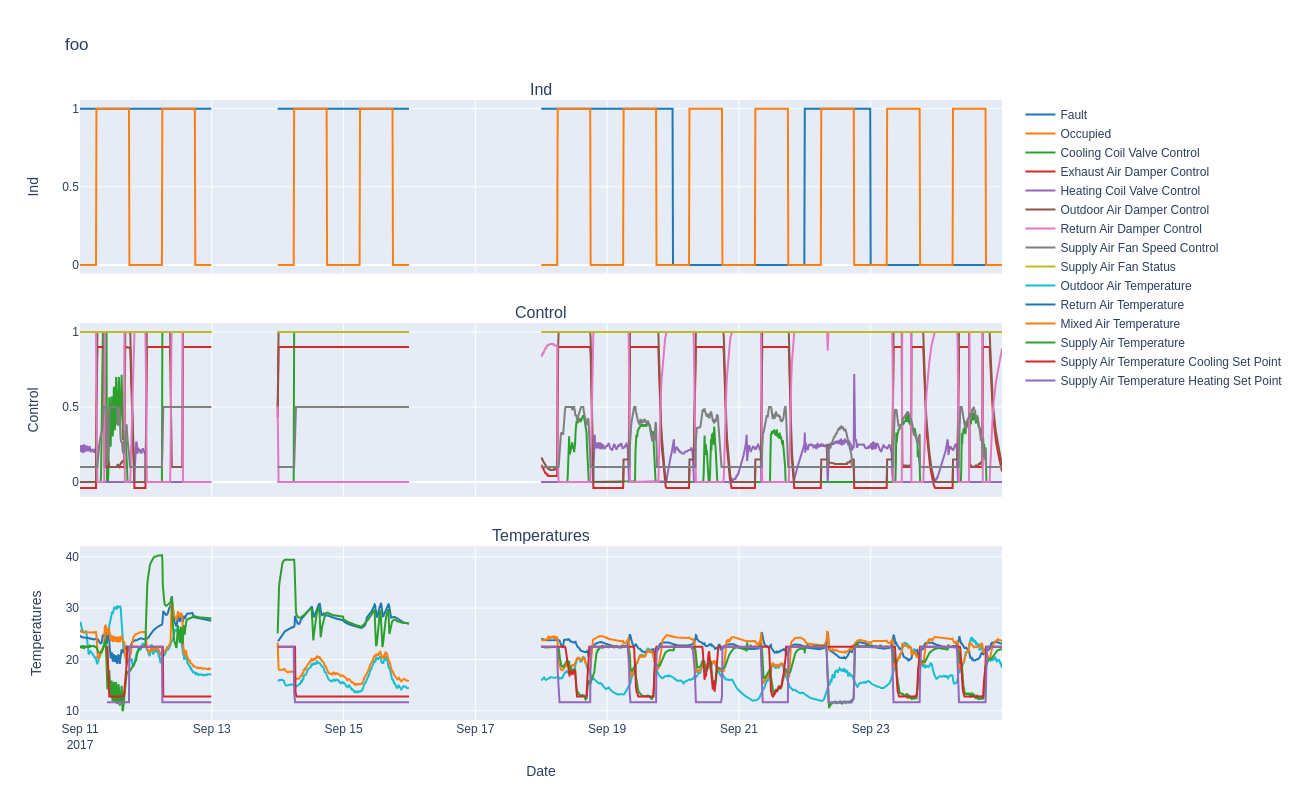

In [7]:

def plot_grouped_timeseries(df, date_col, groups, title="Grouped Time Series", 
                          height=None, colors=None, show_legend=True):

    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import pandas as pd
    import numpy as np

    if height is None:
        height = 200 * len(groups) + 100
    
    # Create subplots
    fig = make_subplots(
        rows=len(groups),
        cols=1,
        subplot_titles=list(groups.keys()),
        vertical_spacing=0.08,
        shared_xaxes=True
    )
    
    # Default colors if not provided
    if colors is None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    color_idx = 0

    df = df.sort_values(date_col)
    
    # Plot each group in its own subplot
    for i, (group_name, columns) in enumerate(groups.items(), 1):
        for col in columns:
            #print(df[col])
            #print()
            y_data = [ float(d) for d in df[col].copy() ] # XXX: no idea why have to convert to floats
            times = df[date_col].values
            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=y_data,
                    mode='lines',
                    #mode='markers',
                    marker=dict(size=3.0),
                    name=col,
                    #legendgroup=group_name,
                    showlegend=show_legend,
                    line=dict(color=colors[color_idx % len(colors)]),
                    #connectgaps=False,
                ),
                row=i, col=1
            )
            color_idx += 1
    
    # Update layout
    fig.update_layout(
        title=title,
        height=height,
        hovermode='x unified',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ) if show_legend else None
    )
    
    # Update axes
    fig.update_xaxes(title_text="Date", row=len(groups), col=1)
    
    for i, group_name in enumerate(groups.keys(), 1):
        fig.update_yaxes(title_text=f"{group_name}", row=i, col=1)
        pass
    
    return fig


indicators = [
    'Fault',
    'Occupied',
]
control = [
    'Cooling Coil Valve Control',
    'Exhaust Air Damper Control',
    'Heating Coil Valve Control',
    'Outdoor Air Damper Control',
    'Return Air Damper Control',
    'Supply Air Fan Speed Control',
    'Supply Air Fan Status',
]
temperatures = [
    'Outdoor Air Temperature',
    'Return Air Temperature',
    'Mixed Air Temperature',
    'Supply Air Temperature',
    'Supply Air Temperature Cooling Set Point',
    'Supply Air Temperature Heating Set Point',
]

# Define groups
groups = {
    'Ind': indicators,
    'Control': control,
    'Temperatures': temperatures,
}

# Create the plot
fig = plot_grouped_timeseries(
    df=df.reset_index(),
    date_col='Time',
    groups=groups,
    title='foo',
    height=800
)
fig.show()

In [5]:
from arimax import ARIMAXAnomalyDetector


Detecting anomalies...

Model coefficients:
ar_lag_1: 0.1419
Occupied: -0.0337
hour: -0.0447
hour_sin: -0.1018
hour_cos: 0.0111
ma_lag_1: 0.2343
SMAPE: 6.86%

Test MSE: 1.7756
Test MAE: 1.0475
Evaluated on 402 valid points


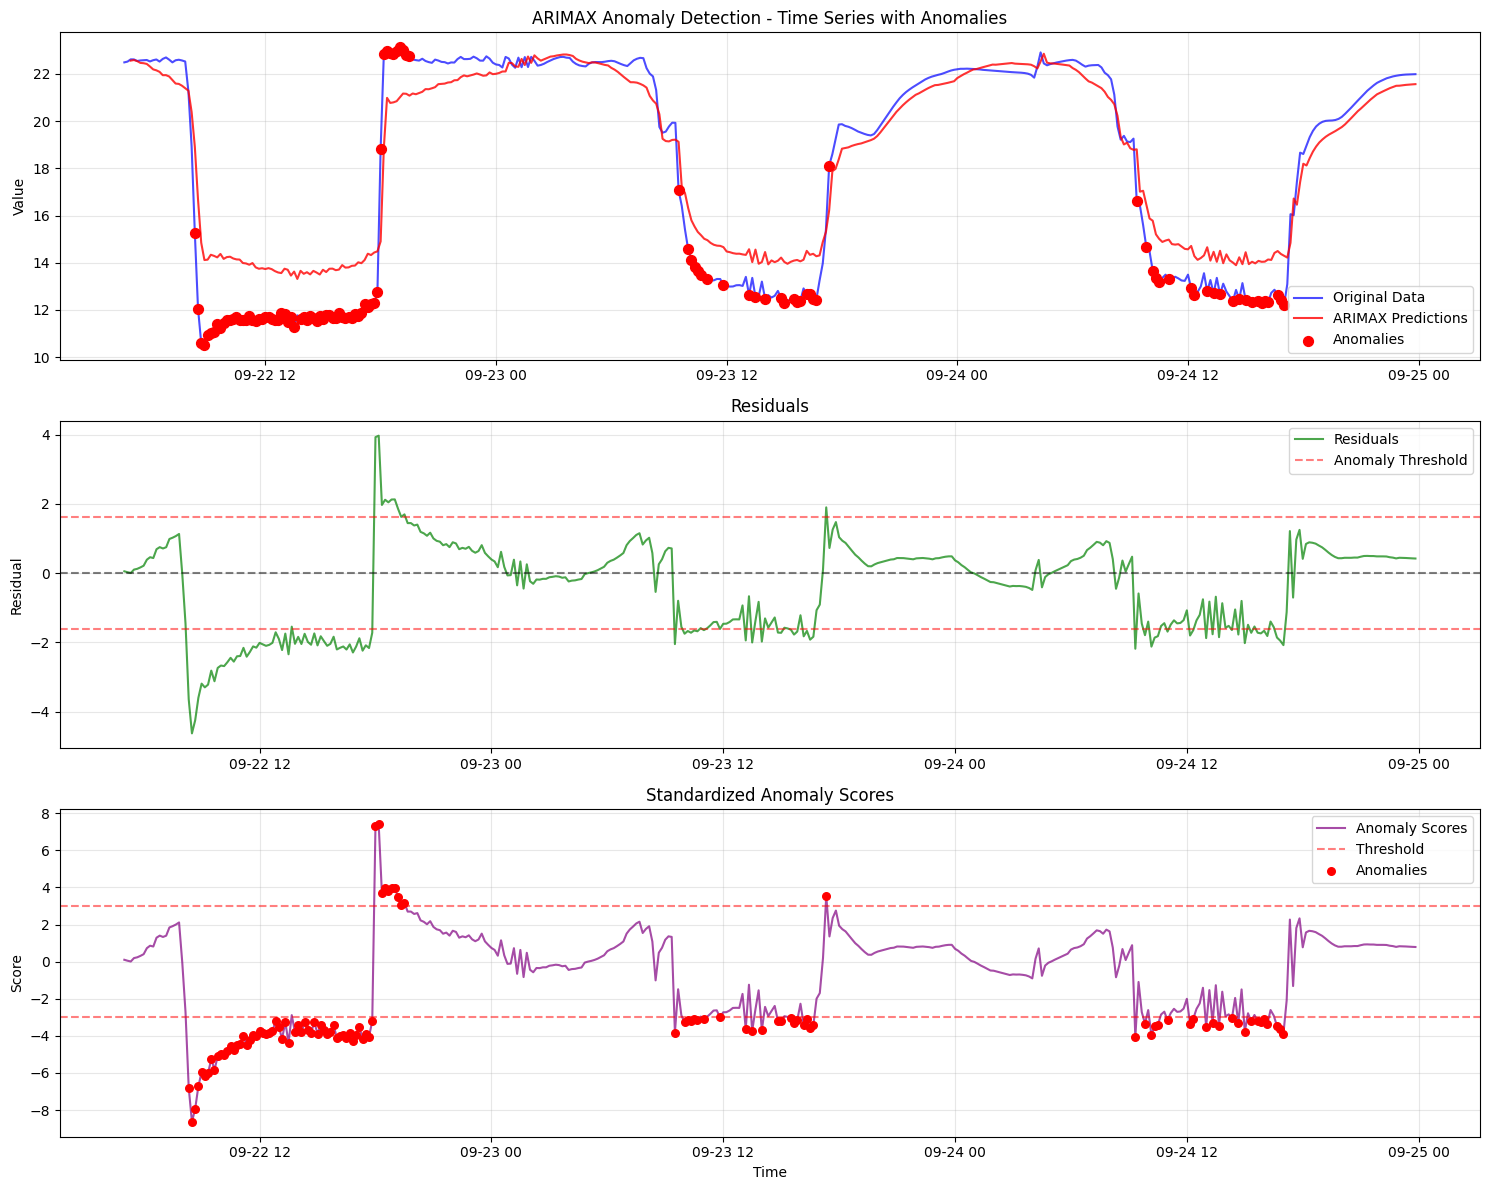

In [25]:

def anomaly_detection(data, target, covariates=[]):
    
    assert isinstance(data.index, pandas.DatetimeIndex), type(data.index)
    assert df.index.is_monotonic_increasing
    
    # Prepare data
    y = data[target]
    X = data[covariates]
    timestamps = data.index

    # Split into train/test
    train_size = int(0.8 * len(data))
    y_train = y[:train_size]
    X_train = X[:train_size]
    timestamps_train = timestamps[:train_size]
    
    y_test = y[train_size:]
    X_test = X[train_size:]
    timestamps_test = timestamps[train_size:]

    seasonal_period = int(pandas.Timedelta(hours=7*24 ) / df.index.freq)

    import elastic_net_linear as enl
    regression = enl.ElasticNetRegression(alpha=0.01, l1_ratio=0.5, max_iterations=1000, verbose=False)

    from sklearn.linear_model import LinearRegression, ElasticNet
    #regression = LinearRegression()
    #regression = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=1000)
    
    arimax_detector = ARIMAXAnomalyDetector(
        ar_order=1,
        ma_order=1,
        diff_order=1,
        seasonal_ar=0,
        seasonal_ma=0,
        seasonal_period=seasonal_period,
        anomaly_threshold=3.0,
        regression_model=regression,
        time_features=['hour'],
    )

    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    arimax_detector.fit(y_train, X_train, timestamps_train)
    
    # Detect anomalies on test data
    print("Detecting anomalies...")
    anomaly_scores, anomalies, predictions = arimax_detector.detect_anomalies(
        y_test, X_test, timestamps_test
    )
    
    # Print feature importance (coefficients)
    print("\nModel coefficients:")
    for i, coef in enumerate(arimax_detector.model.coef_):
        if i < len(arimax_detector.feature_names_):
            print(f"{arimax_detector.feature_names_[i]}: {coef:.4f}")
    
    # Calculate performance metrics on aligned data
    valid_mask = ~(y_test.isna() | predictions.isna())
    y_test_aligned = y_test[valid_mask]
    predictions_aligned = predictions[valid_mask]

    np = numpy
    def smape(y_true, y_pred):
       """Symmetric Mean Absolute Percentage Error"""
       return 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

    # Usage with the ARIMAX model
    valid_mask = ~(y_test.isna() | predictions.isna())
    smape_score = smape(y_test[valid_mask], predictions[valid_mask])
    print(f"SMAPE: {smape_score:.2f}%")
    
    if len(y_test_aligned) > 0:
        test_mse = mean_squared_error(y_test_aligned, predictions_aligned)
        test_mae = mean_absolute_error(y_test_aligned, predictions_aligned)
        print(f"\nTest MSE: {test_mse:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
        print(f"Evaluated on {len(y_test_aligned)} valid points")
    else:
        print("\nNo valid predictions to evaluate")
    
    # Plot results
    arimax_detector.plot_results(y_test, anomaly_scores, anomalies, predictions)

covariates = [
    'Occupied',
    #'Outdoor Air Temperature',
]
anomaly_detection(df, target='Supply Air Temperature', covariates=covariates)

In [ ]:
from darts import TimeSeries
from darts.models import ARIMA
import pandas as pd

In [ ]:



# Convert to Darts TimeSeries
ts = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['target'])
exog = TimeSeries.from_dataframe(df, time_col='timestamp', value_cols=['outdoor_temp', 'occupancy'])

# Fit ARIMAX
model = ARIMA(p=1, d=1, q=0)
model.fit(ts, future_covariates=exog)

# Predict
forecast = model.predict(n=100, future_covariates=exog_future)
